<a href="https://colab.research.google.com/github/fellowship/deep-and-wide-bandit/blob/dev/Generated_Dataset_Aleksey_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Imports

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import json
import pickle as pkl
import gc
from functools import reduce
from collections import defaultdict
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

import random
import seaborn as sns
from pprint import pprint
from sklearn.metrics import confusion_matrix

from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

#Makes panda and numpy easier to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(precision=3, suppress=True)

# Importing the Data

In [4]:
#Initialize a control variable that determines whether we will import data
reexport_var = False
project_folder = Path("/content/drive/MyDrive/Bandit_Project/generated_data_4_project")
train_path = project_folder/"train.csv"
val_path = project_folder/"val.csv"
test_path = project_folder/"test.csv"

In [5]:
if reexport_var:
  input_file = Path("/content/drive/MyDrive/Bandit_Project/BanditsData/generated4.csv")
  df = pd.read_csv(input_file, header=[0])

  #Subtract the optimal_action by 1 so as to make them compatible with tf.estimator
  df["optimal_action"] = df["optimal_action"] - 1
  df.head()

In [6]:
if reexport_var:
  #Splitting into training & test set - 60-20-20 split
  train_split_index = int(0.6 * len(df))
  val_split_index = int(0.8 * len(df))

  df_temp = df.copy()
  df_temp = df_temp.sample(frac=1, random_state=42).reset_index()

  train_df = df_temp.loc[:train_split_index, :]
  val_df = df_temp.loc[train_split_index:val_split_index, :]
  test_df = df_temp.loc[val_split_index:, :]

  #Printing the dataframes
  print(f"[INFO] The training dataframe has {len(train_df)} instances from indices {0} to {train_split_index-1}")
  train_df.head()
  print(f"[INFO] The validation dataframe has {len(val_df)} instances from indices {train_split_index} to {val_split_index - 1}")
  val_df.head()
  print(f"[INFO] The training dataframe has {len(test_df)} instances from indices {val_split_index} to {len(df)}")
  test_df.head()

  #Export training and test set into separate CSV files
  train_df.to_csv(train_path, index=False, header=True)
  val_df.to_csv(val_path, index=False, header=True)
  test_df.to_csv(test_path, index=False, header=True)

In [7]:
print(f"[INFO] Does training data exist? {train_path.exists()}")
print(f"[INFO] Does val data exist? {val_path.exists()}")
print(f"[INFO] Does test data exist? {test_path.exists()}")

[INFO] Does training data exist? True
[INFO] Does val data exist? True
[INFO] Does test data exist? True


# Preparing Dataset for evaluation

In [8]:
#Given a df patterns, convert them to DL
def df_to_dataloader(file_path, feature_columns, target, batch_size=32, shuffle=True, subtract=False):
  
  use_cols = feature_columns + [target]
  dataframe = pd.read_csv(file_path, usecols=use_cols)[use_cols]
  labels = dataframe.pop(target)
  if subtract:
    labels -= 1
  labels = tf.one_hot(labels, depth=10)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  dl = ds.batch(batch_size)
  return dl

In [9]:
#Given CSV file patterns, convert them to DL
def csv_to_dataloader(file_pattern, feature_cols, target_col, shuffle=True, 
                       batch_size=1024, n_epochs = None):
  
  select_cols = feature_cols + [target_col]
  return tf.data.experimental.make_csv_dataset(file_pattern = file_pattern, 
                                             batch_size = batch_size,
                                             label_name = target_col,
                                             select_columns = select_cols,
                                             header=True, 
                                             num_epochs=n_epochs,
                                             shuffle=shuffle,  
                                             shuffle_seed=42,
                                             ignore_errors=True)

In [10]:
batch_size=2048
n_epochs=500

feature_columns = ["user_id", "user_feature_1", "user_feature_2", "campaign_id", 
"campaign_feature_1", "campaign_feature_2"]
target_column = "optimal_action"

train_dl = df_to_dataloader(train_path, feature_columns, target_column, batch_size=batch_size)
val_dl = df_to_dataloader(val_path, feature_columns, target_column, batch_size=batch_size)
test_dl = df_to_dataloader(test_path, feature_columns, target_column, shuffle = False, batch_size=batch_size)

#train_dl = csv_to_dataloader(str(train_path), feature_columns, target_column, batch_size=batch_size, n_epochs = n_epochs)
#val_dl = csv_to_dataloader(str(val_path), feature_columns, target_column, batch_size=batch_size, n_epochs = n_epochs)
#test_dl = csv_to_dataloader(str(test_path), feature_columns, target_column, shuffle = False, batch_size=batch_size, n_epochs = n_epochs)

print("[INFO] Train dataloader:")
pprint(train_dl)
print("[INFO] Val dataloader:")
pprint(val_dl)
print("[INFO] Test dataloader:")
pprint(test_dl)

[INFO] Train dataloader:
<BatchDataset shapes: ({user_id: (None,), user_feature_1: (None,), user_feature_2: (None,), campaign_id: (None,), campaign_feature_1: (None,), campaign_feature_2: (None,)}, (None, 10)), types: ({user_id: tf.int64, user_feature_1: tf.float64, user_feature_2: tf.float64, campaign_id: tf.int64, campaign_feature_1: tf.float64, campaign_feature_2: tf.float64}, tf.float32)>
[INFO] Val dataloader:
<BatchDataset shapes: ({user_id: (None,), user_feature_1: (None,), user_feature_2: (None,), campaign_id: (None,), campaign_feature_1: (None,), campaign_feature_2: (None,)}, (None, 10)), types: ({user_id: tf.int64, user_feature_1: tf.float64, user_feature_2: tf.float64, campaign_id: tf.int64, campaign_feature_1: tf.float64, campaign_feature_2: tf.float64}, tf.float32)>
[INFO] Test dataloader:
<BatchDataset shapes: ({user_id: (None,), user_feature_1: (None,), user_feature_2: (None,), campaign_id: (None,), campaign_feature_1: (None,), campaign_feature_2: (None,)}, (None, 10)), 

# Creating TF Feature Columns

## Numeric

In [11]:
#Initialize
numeric_feature_columns = []
numeric_feature_column_inputs = {}
numeric_df_col_names = ["user_feature_1", "user_feature_2", 
                        "campaign_feature_1", "campaign_feature_2"]

for col_name in numeric_df_col_names:
  tf_nfc = tf.feature_column.numeric_column(col_name)
  numeric_feature_columns.append(tf_nfc)
  numeric_feature_column_inputs[col_name] = tf.keras.Input(shape=(), name=col_name)

## Embedding



In [12]:
#Initialize
embedding_feature_columns = []
embedding_feature_column_inputs = {}

user_id = tf.feature_column.categorical_column_with_hash_bucket("user_id", hash_bucket_size=1000, dtype=tf.int64)
campaign_id = tf.feature_column.categorical_column_with_hash_bucket("campaign_id", hash_bucket_size=100, dtype=tf.int64)

user_id_embedding = tf.feature_column.embedding_column(user_id, dimension=16)
embedding_feature_columns.append(user_id_embedding)
embedding_feature_column_inputs["user_id"] = tf.keras.Input(shape=(), name="user_id", dtype=tf.int64)

campaign_id_embedding = tf.feature_column.embedding_column(campaign_id, dimension=7)
embedding_feature_columns.append(campaign_id_embedding)
embedding_feature_column_inputs["campaign_id"] = tf.keras.Input(shape=(), name="campaign_id", dtype=tf.int64)

## Crossed Columns

In [13]:
user_campaign_cross = tf.feature_column.crossed_column(["user_id", "campaign_id"], hash_bucket_size=100000)
user_campaign_cross_col = [tf.feature_column.indicator_column(user_campaign_cross)]

In [14]:
#Defining the inputs that will be fed to each model
#For W only —> numeric used as it is, categorical used in crosses
#For D only —> numeric used as it is, categorical used through embeddings
#For W&D —> numeric + categorical embedding IN deep, categorical crosses in Wide
inputs = {**numeric_feature_column_inputs, **embedding_feature_column_inputs}

# Models

In [15]:
#Results CSV file to save predictions from each of the models
#results = pd.DataFrame()
result_csv_path = project_folder/"results.csv"

In [16]:
models_dir = project_folder/"models"
models_dir.mkdir(exist_ok=True)

#Create the folders to save the checkpoints
wmodel_dir = (models_dir/"Wide")
dmodel_dir = (models_dir/"Deep")
wdmodel_dir = (models_dir/"W&D")
bayesian_dir = (models_dir/"Bayesian")

wmodel_dir.mkdir(exist_ok=True)
print(f"[INFO] Model folder created for wide only model: {wmodel_dir.exists()}")
dmodel_dir.mkdir(exist_ok=True)
print(f"[INFO] Model folder created for deep only model: {dmodel_dir.exists()}")
wdmodel_dir.mkdir(exist_ok=True)
print(f"[INFO] Model folder created for wide + deep model: {wdmodel_dir.exists()}")
bayesian_dir.mkdir(exist_ok=True)
print(f"[INFO] Model folder created for Bayesian wide + deep model: {bayesian_dir.exists()}")

#Setting hyperparams
lr = 1e-3
gc.collect()

[INFO] Model folder created for wide only model: True
[INFO] Model folder created for deep only model: True
[INFO] Model folder created for wide + deep model: True
[INFO] Model folder created for Bayesian wide + deep model: True


203

## Wide Only Model

In [17]:
wide_only_feature_columns = numeric_feature_columns + user_campaign_cross_col
wmodel_path = wmodel_dir/"wmodel.h5"
wmodel_checkpoint_path = wmodel_dir/"wmodel_checkpoint.h5"

#simple early stopping
w_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
w_mc = tf.keras.callbacks.ModelCheckpoint(str(wmodel_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Only Model
w_feature_layer = tf.keras.layers.DenseFeatures(wide_only_feature_columns, name="dense_feature_layer")(inputs)
w_linear_layer = tf.keras.layers.Dense(10, activation="softmax", name="wide_output")(w_feature_layer)
wmodel = tf.keras.Model(inputs = inputs, outputs=w_linear_layer)
wmodel.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
wmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
campaign_feature_1 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_feature_2 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
user_feature_1 (InputLayer)     [(None,)]            0                                            
______________________________________________________________________________________________

In [18]:
"""
H = wmodel.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[w_es, w_mc])
"""

'\nH = wmodel.fit(train_dl, batch_size=batch_size, epochs=n_epochs, \n               validation_data=val_dl, shuffle=False, \n               validation_batch_size=batch_size, callbacks=[w_es, w_mc])\n'

In [19]:
"""
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()
"""

"\n#Plot the training & validation loss/accuracy curve\nplt.figure()\nplt.style.use('ggplot')\nplt.plot(H.history['accuracy'], label='Training Accuracy')\nplt.plot(H.history['val_accuracy'], label='Validation Accuracy')\nplt.plot(H.history['loss'], label='Training Loss')\nplt.plot(H.history['val_loss'], label='Validation Loss')\nplt.legend()\nplt.title('Accuracy/Loss vs Epochs')\nplt.xlabel('Epoch Number')\nplt.ylabel('Accuracy/Loss')\nplt.show()\n"

In [20]:
"""
#Generate the predictions to a variable
wmodel_predictions = wmodel.predict(test_dl, batch_size=batch_size, verbose=1)
results["wide_only"] = np.argmax(wmodel_predictions, axis=1)
"""

'\n#Generate the predictions to a variable\nwmodel_predictions = wmodel.predict(test_dl, batch_size=batch_size, verbose=1)\nresults["wide_only"] = np.argmax(wmodel_predictions, axis=1)\n'

In [21]:
"""
wmodel.save(str(wmodel_path))
del wmodel
del H
gc.collect()
"""

'\nwmodel.save(str(wmodel_path))\ndel wmodel\ndel H\ngc.collect()\n'

## Deep Only Model

In [22]:
deep_only_feature_columns = numeric_feature_columns + embedding_feature_columns
deep_only_hidden_units = [512, 256, 128]
dmodel_path = dmodel_dir/"model.h5"
dmodel_checkpoint_path = dmodel_dir/"wmodel_checkpoint.h5"

#simple early stopping
d_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
d_mc = tf.keras.callbacks.ModelCheckpoint(str(dmodel_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Only Model
d_feature_layer = tf.keras.layers.DenseFeatures(deep_only_feature_columns, name="dense_feature_layer")(inputs)
d_hidden_layer_1 = tf.keras.layers.Dense(deep_only_hidden_units[0], activation="relu", name="fc_1")(d_feature_layer)
d_hidden_layer_2 = tf.keras.layers.Dense(deep_only_hidden_units[1], activation="relu", name="fc_2")(d_hidden_layer_1)
d_hidden_layer_3 = tf.keras.layers.Dense(deep_only_hidden_units[2], activation="relu", name="fc_3")(d_hidden_layer_2)
d_output_layer = tf.keras.layers.Dense(10, activation="softmax", name="deep_output")(d_hidden_layer_3)

dmodel = tf.keras.Model(inputs = inputs, outputs=d_output_layer)
dmodel.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
dmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
campaign_feature_1 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_feature_2 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
user_feature_1 (InputLayer)     [(None,)]            0                                            
____________________________________________________________________________________________

In [23]:
"""
H = dmodel.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[d_es, d_mc])
"""

'\nH = dmodel.fit(train_dl, batch_size=batch_size, epochs=n_epochs, \n               validation_data=val_dl, shuffle=False, \n               validation_batch_size=batch_size, callbacks=[d_es, d_mc])\n'

In [24]:
"""
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()
"""

"\n#Plot the training & validation loss/accuracy curve\nplt.figure()\nplt.style.use('ggplot')\nplt.plot(H.history['accuracy'], label='Training Accuracy')\nplt.plot(H.history['val_accuracy'], label='Validation Accuracy')\nplt.plot(H.history['loss'], label='Training Loss')\nplt.plot(H.history['val_loss'], label='Validation Loss')\nplt.legend()\nplt.title('Accuracy/Loss vs Epochs')\nplt.xlabel('Epoch Number')\nplt.ylabel('Accuracy/Loss')\nplt.show()\n"

In [25]:
"""
#Generate the predictions to a variable
dmodel_predictions = dmodel.predict(test_dl, batch_size=batch_size, verbose=1)
results["deep_only"] = np.argmax(dmodel_predictions, axis=1)
"""

'\n#Generate the predictions to a variable\ndmodel_predictions = dmodel.predict(test_dl, batch_size=batch_size, verbose=1)\nresults["deep_only"] = np.argmax(dmodel_predictions, axis=1)\n'

In [26]:
"""
dmodel.save(str(dmodel_path))
del dmodel
del H
gc.collect()
"""

'\ndmodel.save(str(dmodel_path))\ndel dmodel\ndel H\ngc.collect()\n'

## Wide & Deep Model: 1

Wide part receives the crossed columns
Deep part receives the numeric features & embeddings

In [27]:
wide_wd_1_feature_columns = user_campaign_cross_col
deep_wd_1_feature_columns = numeric_feature_columns + embedding_feature_columns

deep_wd_1_hidden_units = [512, 256, 128]

wdmodel_1_path = wdmodel_dir/"wdmodel_1.h5"
wdmodel_1_checkpoint_path = wdmodel_dir/"wdmodel_1_checkpoint.h5"

wdmodel_1 = tf.keras.models.load_model(wdmodel_1_path)
wdmodel_1.summary()
"""
#simple early stopping
wd_1_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
wd_1_mc = tf.keras.callbacks.ModelCheckpoint(str(wdmodel_1_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Model
w_feature_layer = tf.keras.layers.DenseFeatures(wide_wd_1_feature_columns, name="wide_feature_layer")(inputs)

#Build the Deep Model
d_feature_layer = tf.keras.layers.DenseFeatures(deep_wd_1_feature_columns, name="deep_feature_layer")(inputs)
d_hidden_layer_1 = tf.keras.layers.Dense(deep_wd_1_hidden_units[0], activation="relu", name="deep_fc_1")(d_feature_layer)
d_hidden_layer_2 = tf.keras.layers.Dense(deep_wd_1_hidden_units[1], activation="relu", name="deep_fc_2")(d_hidden_layer_1)
d_hidden_layer_3 = tf.keras.layers.Dense(deep_wd_1_hidden_units[2], activation="relu", name="deep_fc_3")(d_hidden_layer_2)

#Combine the Wide & Deep
wd_1_both = tf.keras.layers.concatenate([w_feature_layer, d_hidden_layer_3])
wd_1_output_layer = tf.keras.layers.Dense(10, activation="softmax", name="deep_output")(wd_1_both)

wd_1_model = tf.keras.Model(inputs = inputs, outputs=wd_1_output_layer)
wd_1_model.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
wd_1_model.summary()
"""

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
campaign_feature_1 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_feature_2 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
user_feature_1 (InputLayer)     [(None,)]            0                                            
______________________________________________________________________________________________

'\n#simple early stopping\nwd_1_es = tf.keras.callbacks.EarlyStopping(monitor=\'val_loss\', mode=\'min\', verbose=1, patience=10)\nwd_1_mc = tf.keras.callbacks.ModelCheckpoint(str(wdmodel_1_checkpoint_path), monitor=\'val_accuracy\', mode=\'max\', verbose=1, save_best_only=True)\n\n#Build the Wide Model\nw_feature_layer = tf.keras.layers.DenseFeatures(wide_wd_1_feature_columns, name="wide_feature_layer")(inputs)\n\n#Build the Deep Model\nd_feature_layer = tf.keras.layers.DenseFeatures(deep_wd_1_feature_columns, name="deep_feature_layer")(inputs)\nd_hidden_layer_1 = tf.keras.layers.Dense(deep_wd_1_hidden_units[0], activation="relu", name="deep_fc_1")(d_feature_layer)\nd_hidden_layer_2 = tf.keras.layers.Dense(deep_wd_1_hidden_units[1], activation="relu", name="deep_fc_2")(d_hidden_layer_1)\nd_hidden_layer_3 = tf.keras.layers.Dense(deep_wd_1_hidden_units[2], activation="relu", name="deep_fc_3")(d_hidden_layer_2)\n\n#Combine the Wide & Deep\nwd_1_both = tf.keras.layers.concatenate([w_featu

In [28]:
"""
#Model is already trained - load the model directly

H = wd_1_model.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[wd_1_es, wd_1_mc])
"""

'\n#Model is already trained - load the model directly\n\nH = wd_1_model.fit(train_dl, batch_size=batch_size, epochs=n_epochs, \n               validation_data=val_dl, shuffle=False, \n               validation_batch_size=batch_size, callbacks=[wd_1_es, wd_1_mc])\n'

In [29]:
""""
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()
"""

'"\n#Plot the training & validation loss/accuracy curve\nplt.figure()\nplt.style.use(\'ggplot\')\nplt.plot(H.history[\'accuracy\'], label=\'Training Accuracy\')\nplt.plot(H.history[\'val_accuracy\'], label=\'Validation Accuracy\')\nplt.plot(H.history[\'loss\'], label=\'Training Loss\')\nplt.plot(H.history[\'val_loss\'], label=\'Validation Loss\')\nplt.legend()\nplt.title(\'Accuracy/Loss vs Epochs\')\nplt.xlabel(\'Epoch Number\')\nplt.ylabel(\'Accuracy/Loss\')\nplt.show()\n'

In [30]:
"""
#Generate the predictions to a variable
wd_1_predictions = wd_1_model.predict(test_dl, batch_size=batch_size, verbose=1)
results["wide_deep_1"] = np.argmax(wd_1_predictions, axis=1)
"""

'\n#Generate the predictions to a variable\nwd_1_predictions = wd_1_model.predict(test_dl, batch_size=batch_size, verbose=1)\nresults["wide_deep_1"] = np.argmax(wd_1_predictions, axis=1)\n'

In [31]:
"""
wd_1_model.save(str(wdmodel_1_path))
del wd_1_model
del H
gc.collect()
"""

'\nwd_1_model.save(str(wdmodel_1_path))\ndel wd_1_model\ndel H\ngc.collect()\n'

## Wide & Deep Model 2

Wide part receives the crossed columns
Deep part receives the numeric features (No embeddings)

In [32]:
wide_wd_2_feature_columns = user_campaign_cross_col
deep_wd_2_feature_columns = numeric_feature_columns

deep_wd_2_hidden_units = [512, 256, 128]

wdmodel_2_path = wdmodel_dir/"wdmodel_2.h5"
wdmodel_2_checkpoint_path = wdmodel_dir/"wdmodel_2_checkpoint.h5"

#simple early stopping
wd_2_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
wd_2_mc = tf.keras.callbacks.ModelCheckpoint(str(wdmodel_2_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Model
w_feature_layer = tf.keras.layers.DenseFeatures(wide_wd_2_feature_columns, name="wide_feature_layer")(inputs)

#Build the Deep Model
d_feature_layer = tf.keras.layers.DenseFeatures(deep_wd_2_feature_columns, name="deep_feature_layer")(inputs)
d_hidden_layer_1 = tf.keras.layers.Dense(deep_wd_2_hidden_units[0], activation="relu", name="deep_fc_1")(d_feature_layer)
d_hidden_layer_2 = tf.keras.layers.Dense(deep_wd_2_hidden_units[1], activation="relu", name="deep_fc_2")(d_hidden_layer_1)
d_hidden_layer_3 = tf.keras.layers.Dense(deep_wd_2_hidden_units[2], activation="relu", name="deep_fc_3")(d_hidden_layer_2)

#Combine the Wide & Deep
wd_2_both = tf.keras.layers.concatenate([w_feature_layer, d_hidden_layer_3])
wd_2_output_layer = tf.keras.layers.Dense(10, activation="softmax", name="deep_output")(wd_2_both)

wd_2_model = tf.keras.Model(inputs = inputs, outputs=wd_2_output_layer)
wd_2_model.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
wd_2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
campaign_feature_1 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_feature_2 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
user_feature_1 (InputLayer)     [(None,)]            0                                            
____________________________________________________________________________________________

In [33]:
"""
H = wd_2_model.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[wd_2_es, wd_2_mc])
"""

'\nH = wd_2_model.fit(train_dl, batch_size=batch_size, epochs=n_epochs, \n               validation_data=val_dl, shuffle=False, \n               validation_batch_size=batch_size, callbacks=[wd_2_es, wd_2_mc])\n'

In [34]:
"""
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()
"""

"\n#Plot the training & validation loss/accuracy curve\nplt.figure()\nplt.style.use('ggplot')\nplt.plot(H.history['accuracy'], label='Training Accuracy')\nplt.plot(H.history['val_accuracy'], label='Validation Accuracy')\nplt.plot(H.history['loss'], label='Training Loss')\nplt.plot(H.history['val_loss'], label='Validation Loss')\nplt.legend()\nplt.title('Accuracy/Loss vs Epochs')\nplt.xlabel('Epoch Number')\nplt.ylabel('Accuracy/Loss')\nplt.show()\n"

In [35]:
"""
#Generate the predictions to a variable
wd_2_predictions = wd_2_model.predict(test_dl, batch_size=batch_size, verbose=1)
results["wide_deep_2"] = np.argmax(wd_2_predictions, axis=1)
"""

'\n#Generate the predictions to a variable\nwd_2_predictions = wd_2_model.predict(test_dl, batch_size=batch_size, verbose=1)\nresults["wide_deep_2"] = np.argmax(wd_2_predictions, axis=1)\n'

In [36]:
"""
wd_2_model.save(str(wdmodel_2_path))
del wd_2_model
del H
gc.collect()
"""

'\nwd_2_model.save(str(wdmodel_2_path))\ndel wd_2_model\ndel H\ngc.collect()\n'

## Bayesian Wide & Deep Model

In [37]:
bayesian_path = bayesian_dir/"bayesian_2.h5"
bayesian_checkpoint_path = bayesian_dir/"bayesian_checkpoint_2.h5"

"""
bayesian_wide_feature_columns = user_campaign_cross_col
bayesian_deep_feature_columns = numeric_feature_columns + embedding_feature_columns

bayesian_deep_hidden_units = [512, 256, 128]

#simple early stopping
bayesian_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
bayesian_mc = tf.keras.callbacks.ModelCheckpoint(str(bayesian_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Model
w_feature_layer = tf.keras.layers.DenseFeatures(wide_wd_1_feature_columns, name="wide_feature_layer")(inputs)

#Build the Deep Model
d_feature_layer = tf.keras.layers.DenseFeatures(deep_wd_1_feature_columns, name="deep_feature_layer")(inputs)
d_hidden_layer_1 = tf.keras.layers.Dense(deep_wd_1_hidden_units[0], activation="relu", name="deep_fc_1")(d_feature_layer)
d_hidden_layer_2 = tf.keras.layers.Dense(deep_wd_1_hidden_units[1], activation="relu", name="deep_fc_2")(d_hidden_layer_1)
d_hidden_layer_3 = tf.keras.layers.Dense(deep_wd_1_hidden_units[2], activation="relu", name="deep_fc_3")(d_hidden_layer_2)

#Combine the Wide & Deep
bayesian_both = tf.keras.layers.concatenate([w_feature_layer, d_hidden_layer_3], name="concatenate") #Name is concatenate_1 for this

#bayesian_pre_multihead_dropout = tf.keras.layers.Dropout(0.3)(bayesian_both, training=True) - Commented out to solve OOM issues
bayesian_multihead = tf.keras.layers.Dense(64, activation="relu", name="multihead")(bayesian_both)
bayesian_dropout = tf.keras.layers.Dropout(0.3, name="dropout")(bayesian_multihead, training=True)

bayesian_output_layer = tf.keras.layers.Dense(10, activation="softmax", name="bayesian_model_output")(bayesian_dropout)

bayesian_model = tf.keras.Model(inputs = inputs, outputs=bayesian_output_layer)

bayesian_model.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
bayesian_model.summary()
"""

'\nbayesian_wide_feature_columns = user_campaign_cross_col\nbayesian_deep_feature_columns = numeric_feature_columns + embedding_feature_columns\n\nbayesian_deep_hidden_units = [512, 256, 128]\n\n#simple early stopping\nbayesian_es = tf.keras.callbacks.EarlyStopping(monitor=\'val_loss\', mode=\'min\', verbose=1, patience=10)\nbayesian_mc = tf.keras.callbacks.ModelCheckpoint(str(bayesian_checkpoint_path), monitor=\'val_accuracy\', mode=\'max\', verbose=1, save_best_only=True)\n\n#Build the Wide Model\nw_feature_layer = tf.keras.layers.DenseFeatures(wide_wd_1_feature_columns, name="wide_feature_layer")(inputs)\n\n#Build the Deep Model\nd_feature_layer = tf.keras.layers.DenseFeatures(deep_wd_1_feature_columns, name="deep_feature_layer")(inputs)\nd_hidden_layer_1 = tf.keras.layers.Dense(deep_wd_1_hidden_units[0], activation="relu", name="deep_fc_1")(d_feature_layer)\nd_hidden_layer_2 = tf.keras.layers.Dense(deep_wd_1_hidden_units[1], activation="relu", name="deep_fc_2")(d_hidden_layer_1)\nd

In [38]:
"""
#For simplicity, enumerate over the test model layers
print("[INFO] The layers of the Bayesian W&D model are:\n")
for i, layer in enumerate(bayesian_model.layers):
  print(f"Layer @ index{i}: {layer} with name {layer.name}")
"""

'\n#For simplicity, enumerate over the test model layers\nprint("[INFO] The layers of the Bayesian W&D model are:\n")\nfor i, layer in enumerate(bayesian_model.layers):\n  print(f"Layer @ index{i}: {layer} with name {layer.name}")\n'

In [39]:
"""
#Load the latest checkpoint and resume training
bayesian_model = tf.keras.models.load_model(str(bayesian_checkpoint_path))
H = bayesian_model.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[bayesian_es, bayesian_mc])
"""

'\n#Load the latest checkpoint and resume training\nbayesian_model = tf.keras.models.load_model(str(bayesian_checkpoint_path))\nH = bayesian_model.fit(train_dl, batch_size=batch_size, epochs=n_epochs, \n               validation_data=val_dl, shuffle=False, \n               validation_batch_size=batch_size, callbacks=[bayesian_es, bayesian_mc])\n'

In [40]:
"""
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()
"""

"\n#Plot the training & validation loss/accuracy curve\nplt.figure()\nplt.style.use('ggplot')\nplt.plot(H.history['accuracy'], label='Training Accuracy')\nplt.plot(H.history['val_accuracy'], label='Validation Accuracy')\nplt.plot(H.history['loss'], label='Training Loss')\nplt.plot(H.history['val_loss'], label='Validation Loss')\nplt.legend()\nplt.title('Accuracy/Loss vs Epochs')\nplt.xlabel('Epoch Number')\nplt.ylabel('Accuracy/Loss')\nplt.show()\n"

In [41]:
"""
bayesian_model.save(str(bayesian_path))
gc.collect()
"""

'\nbayesian_model.save(str(bayesian_path))\ngc.collect()\n'

### Bandits: TS & UCB

In [42]:
"""
test_model = tf.keras.models.load_model(str(bayesian_path))
test_model.summary()
"""

'\ntest_model = tf.keras.models.load_model(str(bayesian_path))\ntest_model.summary()\n'

In [43]:
"""
#For simplicity, enumerate over the test model layers
print("[INFO] The layers of the Bayesian W&D model are:\n")
for i, layer in enumerate(test_model.layers):
  print(f"Layer @ index{i}: {layer} with name {layer.name}")
"""  

'\n#For simplicity, enumerate over the test model layers\nprint("[INFO] The layers of the Bayesian W&D model are:\n")\nfor i, layer in enumerate(test_model.layers):\n  print(f"Layer @ index{i}: {layer} with name {layer.name}")\n'

In [44]:
"""
#Constructing a intermediate wide and deep model to get the static concatenated outputs
layer_name = "multihead"
till_multihead_model = tf.keras.Model(inputs=test_model.input, outputs=test_model.get_layer(layer_name).output)
till_multihead_model.summary()
"""

'\n#Constructing a intermediate wide and deep model to get the static concatenated outputs\nlayer_name = "multihead"\ntill_multihead_model = tf.keras.Model(inputs=test_model.input, outputs=test_model.get_layer(layer_name).output)\ntill_multihead_model.summary()\n'

In [45]:
"""
#Now, constructing the multi-head that the concatenated input has to run through
dropout_input = tf.keras.Input(shape=(64, ), dtype=tf.float32, name="multihead_output")
next_layer = dropout_input
for layer in test_model.layers[13:]:
  if "dropout" in layer.name:
    next_layer = layer(next_layer, training=True)
  else:
    next_layer = layer(next_layer)
post_multihead_model = tf.keras.Model(inputs=dropout_input, outputs=next_layer)
post_multihead_model.summary()
"""

'\n#Now, constructing the multi-head that the concatenated input has to run through\ndropout_input = tf.keras.Input(shape=(64, ), dtype=tf.float32, name="multihead_output")\nnext_layer = dropout_input\nfor layer in test_model.layers[13:]:\n  if "dropout" in layer.name:\n    next_layer = layer(next_layer, training=True)\n  else:\n    next_layer = layer(next_layer)\npost_multihead_model = tf.keras.Model(inputs=dropout_input, outputs=next_layer)\npost_multihead_model.summary()\n'

In [46]:
"""
#Demonstrating how Bayesian network outputs are probabilistic in nature
features_batch, _ = iter(test_dl).get_next()
multihead_output = till_multihead_model.predict(features_batch)
for cnt in range(5):  
  print(f"[INFO] Drawing {cnt + 1} sample for the 1st data point:")
  print("Multihead:", post_multihead_model.predict(multihead_output)[0:1])
  print("Full Model:", test_model.predict(features_batch)[0:1], "\n")
"""

'\n#Demonstrating how Bayesian network outputs are probabilistic in nature\nfeatures_batch, _ = iter(test_dl).get_next()\nmultihead_output = till_multihead_model.predict(features_batch)\nfor cnt in range(5):  \n  print(f"[INFO] Drawing {cnt + 1} sample for the 1st data point:")\n  print("Multihead:", post_multihead_model.predict(multihead_output)[0:1])\n  print("Full Model:", test_model.predict(features_batch)[0:1], "\n")\n'

In [47]:
def find_ucb(raw_samples_l, value_index):
  
  """
  Given a (100, batch_size, 10) list —>
  1) Convert into array
  2) Sort it along axis=0 in descending order
  3) Pick the 5th largest value for every class
  4) Repeat this for all data points
  5) Return a (2048, 10) array

  """
  raw_samples_array = np.array(raw_samples_l)

  #Array is 3D - 0: Samples, 1: Row, 2: Column
  #Sort the array along 0th axis
  raw_samples_array[::-1].sort(axis=0)

  #Pick the 5th largest value
  ucb_batch = raw_samples_array[value_index-1]

  #Return the value
  return ucb_batch

In [48]:
"""
num_of_samples = 100
value_index = num_of_samples - int(0.95 * num_of_samples)
batch_cnt = 0
ts_bandit_output_l = []
ucb_bandit_output_l = []

#Iterate through the Batched Dataset, one batch at a time
for features, _ in test_dl:
  
  if (batch_cnt + 1) % 5 == 0:
    print(f"[INFO] Working on Test Set Batch #{batch_cnt + 1}")

  #Generate predictions of wide_and_deep_model for a given batch
  multihead_output = till_multihead_model.predict(features)
  ucb_working_l = []

  for multi_cnt in range(num_of_samples):

    if not((batch_cnt + 1) % 5) and not((multi_cnt + 1) % 5):
      print(f"[INFO] Drawing sample #{multi_cnt + 1} from the Posterior...")

    output = post_multihead_model.predict(multihead_output)
    
    ucb_working_l.append(output) #Draw multiple samples for UCB
    
    if not(multi_cnt): #Draw only one sample for TS
      ts_bandit_output_l.append(output)
  
  ucb_batch = find_ucb(ucb_working_l, value_index) 
  del multihead_output
  del ucb_working_l
  ucb_bandit_output_l.append(ucb_batch)  
  batch_cnt += 1
  gc.collect()

ts_bandit_output = np.concatenate(ts_bandit_output_l, axis=0)
del ts_bandit_output_l
ucb_bandit_output = np.concatenate(ucb_bandit_output_l, axis=0)
del ucb_bandit_output_l
"""

'\nnum_of_samples = 100\nvalue_index = num_of_samples - int(0.95 * num_of_samples)\nbatch_cnt = 0\nts_bandit_output_l = []\nucb_bandit_output_l = []\n\n#Iterate through the Batched Dataset, one batch at a time\nfor features, _ in test_dl:\n  \n  if (batch_cnt + 1) % 5 == 0:\n    print(f"[INFO] Working on Test Set Batch #{batch_cnt + 1}")\n\n  #Generate predictions of wide_and_deep_model for a given batch\n  multihead_output = till_multihead_model.predict(features)\n  ucb_working_l = []\n\n  for multi_cnt in range(num_of_samples):\n\n    if not((batch_cnt + 1) % 5) and not((multi_cnt + 1) % 5):\n      print(f"[INFO] Drawing sample #{multi_cnt + 1} from the Posterior...")\n\n    output = post_multihead_model.predict(multihead_output)\n    \n    ucb_working_l.append(output) #Draw multiple samples for UCB\n    \n    if not(multi_cnt): #Draw only one sample for TS\n      ts_bandit_output_l.append(output)\n  \n  ucb_batch = find_ucb(ucb_working_l, value_index) \n  del multihead_output\n  del

In [49]:
"""
#Check whether the shapes are the same
assert (ts_bandit_output.shape) == (ucb_bandit_output.shape)

#Print the 1st element of both TS and UCB
print("[INFO] TS output for 1st data point:")
pprint(ts_bandit_output[0])
print("[INFO] UCB output for 1st data point:")
pprint(ucb_bandit_output[0])

#Save results of the run
ts_bandit_result_path = project_folder/"ts.npy"
np.save(ts_bandit_result_path, ts_bandit_output)
ucb_bandit_result_path = project_folder/"ucb.npy"
np.save(ucb_bandit_result_path, ucb_bandit_output)

gc.collect()
"""

'\n#Check whether the shapes are the same\nassert (ts_bandit_output.shape) == (ucb_bandit_output.shape)\n\n#Print the 1st element of both TS and UCB\nprint("[INFO] TS output for 1st data point:")\npprint(ts_bandit_output[0])\nprint("[INFO] UCB output for 1st data point:")\npprint(ucb_bandit_output[0])\n\n#Save results of the run\nts_bandit_result_path = project_folder/"ts.npy"\nnp.save(ts_bandit_result_path, ts_bandit_output)\nucb_bandit_result_path = project_folder/"ucb.npy"\nnp.save(ucb_bandit_result_path, ucb_bandit_output)\n\ngc.collect()\n'

# Results

## Loading prediction results

In [50]:
results = pd.read_csv(result_csv_path, header=[0])
#results["w&d_1_ts"] = np.argmax(ts_bandit_output, axis=1)
#results["w&d_1_ucb"] = np.argmax(ucb_bandit_output, axis=1)

## Saving prediction results 

In [51]:
#results.to_csv(result_csv_path, header=True, index=False)
results.head()

,wide_deep_1,wide_deep_2,wide_only,deep_only,target,w&d_1_ts,w&d_1_ucb
0,4,4,4,4,4,4,4
1,1,2,2,4,0,1,1
2,4,4,5,4,4,4,4
3,2,2,2,2,2,2,2
4,9,9,4,9,9,9,9


In [52]:
for model_type in ["wide_only", "deep_only", "wide_deep_1", "wide_deep_2","w&d_1_ts", "w&d_1_ucb"]:
  acc = ((results[model_type] == results["target"]).astype(int).sum())/len(results)
  print(f"[INFO] {model_type} accuracy: {acc}")

[INFO] wide_only accuracy: 0.3360835
[INFO] deep_only accuracy: 0.807614
[INFO] wide_deep_1 accuracy: 0.806596
[INFO] wide_deep_2 accuracy: 0.772791
[INFO] w&d_1_ts accuracy: 0.792291
[INFO] w&d_1_ucb accuracy: 0.802016


## Evaluating Accuracy vs. freq of seeing user

For all models, run through the full dataset and evaluate how user accuracy varies with the frequence of seeing users.

In [53]:
"""
def build_user_freq_dictionary(batched_ds):
  
  #Editing this out because the next function can handle this functionality
  #Given a Batched Dataset, build a dictionary of unique user IDs along
  #with the # of times they have been seen in the full Batched Dataset
  
  user_freqs = defaultdict(int)
  
  with tqdm(total=len(batched_ds)) as progress_bar:        
  
    for feature_batch, _ in batched_ds:

      #Get unique values of "user_id" from feature_batch
      unique_ids, unique_counts = np.unique(feature_batch['user_id'].numpy(), return_counts=True)

      #Iterate and increment
      for id, count in zip(unique_ids, unique_counts):
        user_freqs[id] += count
      
      progress_bar.update(1)
    
  return user_freqs
"""

In [64]:
start = int(0*batch_size)
stop = int(batch_size)
model_output_batch = pred_outputs[start:stop]
feature_batch, label_batch = iter(main_ds).get_next()
label_batch_array = np.argmax(label_batch.numpy(), axis=1)
print(model_output_batch)
print(model_output_batch.shape)
print(label_batch_array)
print(label_batch_array.shape)
comparison = (model_output_batch == label_batch_array).astype(int)
print(comparison)
print(np.sum(comparison)/comparison.shape[0])
"""
count = 0
accu = 0

temp_dict = defaultdict(int)
feature_batch, label_batch = iter(main_ds).get_next()
user_id_array = feature_batch['user_id'].numpy()
label_array = label_batch.numpy()

"""

[1 7 2 ... 7 2 8]
(2048,)
[2 6 2 ... 8 2 8]
(2048,)
[0 0 1 ... 0 1 1]
0.861328125


"\ncount = 0\naccu = 0\n\ntemp_dict = defaultdict(int)\nfeature_batch, label_batch = iter(main_ds).get_next()\nuser_id_array = feature_batch['user_id'].numpy()\nlabel_array = label_batch.numpy()\n\n"

In [68]:
def build_user_accuracy_dictionary(batched_ds, model_outputs):

  """ 
  Given a Batched Dataset and a model, build a dictionary of unique user IDs 
  along with their accuracy values in the batched dataset. As an interim step,
  we use a list of 1s and 0s denoting correct/incorrect predictions to compute
  these accuracy values
  """
  user_results = defaultdict(list)
  user_acc = defaultdict(int)
  counter = 0 #For subsetting model_outputs
  
  with tqdm(total=len(batched_ds)) as progress_bar:  
    for feature_batch, label_batch in batched_ds:    

      model_output_batch = model_outputs[int(counter*batch_size):int((counter+1)*batch_size)]
      user_id_numpy = feature_batch["user_id"].numpy()
      unique_ids = np.unique(user_id_numpy)    
      #pred_batch = np.argmax(model.predict(feature_batch), axis=1)            
      opt_action_numpy = np.argmax(label_batch.numpy(), axis=1)
      comparison = (opt_action_numpy == model_output_batch).astype(int)
          
      for user_id in unique_ids:
        
        idx = np.where(user_id_numpy == user_id)
        user_results[user_id].append(comparison[idx])
        #pred_user_id = model_outputs[idx]
        #target_user_id = opt_action_numpy[idx]      
        #user_results[user_id].append(list((pred_user_id == target_user_id).astype(int)))
        
      counter += 1
      progress_bar.update(1) # update progress
      
  for key, val in user_results.items():
    user_results[key] = np.concatenate(val, axis=0)
    user_acc[key] = np.mean(user_results[key])

  return user_results, user_acc

In [118]:
def plot_accuracy_frequency(user_results, user_acc_scores, bin_interval = 500):
  """
  Given a user frequency dictionary and a user accuracy dictionary, 
  generate an accuracy vs. frequency plot. Both dicts share the same keys.
  """
  #Get frequency of each user ID
  freqs = [user_result.shape[0] for _, user_result in user_results.items()]

  #Get accuracy of each user ID
  accs = [user_acc for _, user_acc in user_acc_scores.items()]
  
  #If freqs repeat, take their mean accuracy + keep only 1 occurrence in the freq vector
  #One strategy is to convert the 2 lists to a DataFrame and use groupby
  df = pd.DataFrame({'frequency': freqs, 'accuracy': accs})
  df_unique = df.groupby("frequency", sort=True)["accuracy"].mean().reset_index()
  df_unique.plot.scatter(x="frequency", y="accuracy", figsize=(20,6), title="Accuracy vs. Frequency", ylabel="Accuracy (Full Dataset)", xlabel="Seen Frequency")

  #Bin the frequency data
  bins = range(0, 20100, bin_interval)
  df_unique["frequency_bins"] = pd.cut(df_unique["frequency"], bins)

  #Group as per the bin
  df_bin_group = df_unique.groupby("frequency_bins", sort=True)["accuracy"].mean().reset_index()
  ax = df_bin_group.plot.bar(x="frequency_bins", y="accuracy", rot=45, figsize=(20,6), title="Accuracy vs. Frequency Bins", ylabel="accuracy", xlabel="frequency (Bins)")

In [57]:
#Create the main batched dataset
main_ds = df_to_dataloader(Path("/content/drive/MyDrive/Bandit_Project/BanditsData/generated4.csv"), 
                 feature_columns, 
                 target_column, 
                 batch_size=batch_size,
                 shuffle=False,
                 subtract=True)

In [58]:
#Generate the user frequency dictionary
#user_freq = build_user_freq_dictionary(main_ds)

100%|██████████| 4883/4883 [00:21<00:00, 228.37it/s]


In [59]:
"""
#Editing this out because next function handles this functionality
#Display outputs for inspection
num_users, num_times = (0, 0)
for key, val in user_freq.items():
  num_users += 1
  num_times += val

#Display purposes
print(f"[INFO] There are {num_users} unique users and {num_times} observations.")
cnt = 0
for key, val in user_freq.items():
  print(f"[INFO] User #{key} has been seen {val} times")
  cnt += 1
  if cnt == 10:
    break
"""

[INFO] There are 1000 unique users and 10000000 observations.
[INFO] User #1 has been seen 12060 times
[INFO] User #4 has been seen 11641 times
[INFO] User #5 has been seen 1273 times
[INFO] User #7 has been seen 9216 times
[INFO] User #8 has been seen 16001 times
[INFO] User #9 has been seen 2857 times
[INFO] User #10 has been seen 17601 times
[INFO] User #11 has been seen 4839 times
[INFO] User #12 has been seen 9091 times
[INFO] User #14 has been seen 5810 times


In [60]:
#Generate softmax and class outputs
predictions = wdmodel_1.predict(main_ds, verbose=1)
pred_outputs = np.argmax(predictions, axis=1)

#Evaluate on the full set —> This was done for debugging. Passed.
#results = wdmodel_1.evaluate(main_ds)
#results

4883/4883 [==============================] - 133s 27ms/step


In [69]:
user_results, user_acc_scores = build_user_accuracy_dictionary(main_ds, pred_outputs)

100%|██████████| 4883/4883 [00:39<00:00, 122.37it/s]


In [73]:
#Display outputs for inspection
num_users, num_times = (0, 0)
for key, val in user_results.items():
  num_users += 1
  num_times += val.shape[0]

#Display to see what's going on
print(f"[INFO] There are {num_users} unique users and {num_times} observations.")
cnt = 0
for key, val in user_results.items():
  print(f"[INFO] User ID {key}: Seen {val.shape[0]} times, Avg Acc. {user_acc_scores[key]:.3f}")
  cnt += 1
  if cnt == 10:
    break

[INFO] There are 1000 unique users and 10000000 observations.
[INFO] User ID 1: Seen 12060 times, Avg Acc. 0.818
[INFO] User ID 4: Seen 11641 times, Avg Acc. 0.798
[INFO] User ID 5: Seen 1273 times, Avg Acc. 0.817
[INFO] User ID 7: Seen 9216 times, Avg Acc. 0.741
[INFO] User ID 8: Seen 16001 times, Avg Acc. 0.935
[INFO] User ID 9: Seen 2857 times, Avg Acc. 0.779
[INFO] User ID 10: Seen 17601 times, Avg Acc. 0.847
[INFO] User ID 11: Seen 4839 times, Avg Acc. 0.872
[INFO] User ID 12: Seen 9091 times, Avg Acc. 0.786
[INFO] User ID 14: Seen 5810 times, Avg Acc. 0.714


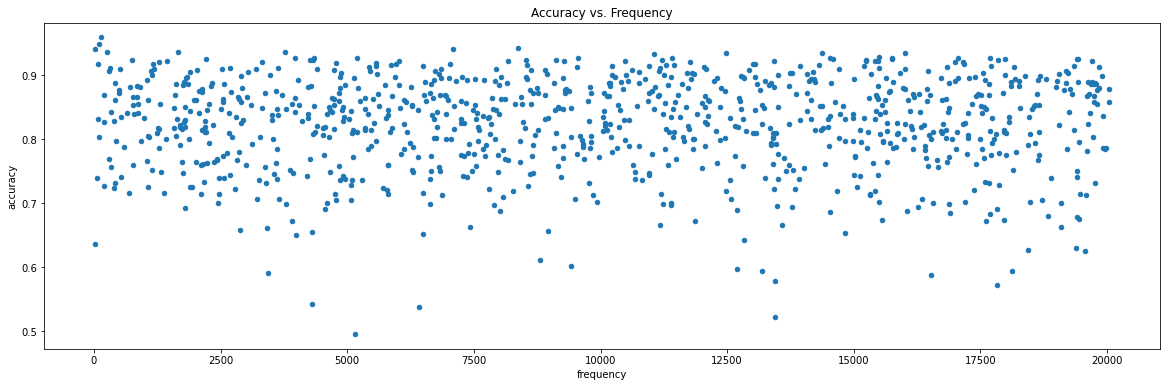

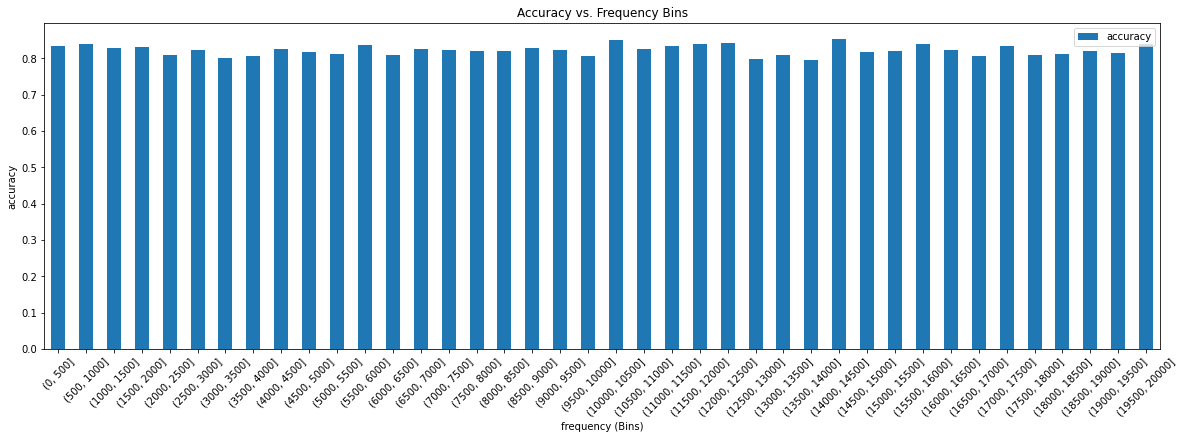

In [119]:
plot_accuracy_frequency(user_results, user_acc_scores)